In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import uproot
from tqdm import trange
from tqdm import tqdm
import matplotlib.patheffects as pe
from scipy.interpolate import interp1d

import NESTModel
from s2widthFast import WidthModel

plt.style.use('style.mplstyle')

In [2]:
# Exponential sampling helper
def sample_exponential_in_range(low, high, size, scale=None):
    """
    Sample 'size' points from an exponential distribution truncated between 'low' and 'high'.
    scale: the exponential scale parameter (mean). If None, defaults to 0.3*(high-low)
    """
    if scale is None:
        scale = 0.3 * (high - low)
    # sample until all values are within [low, high]
    samples = np.empty(size)
    for i in range(size):
        while True:
            x = np.random.exponential(scale)
            if low <= x <= high:
                samples[i] = x
                break
    return samples

In [3]:
S1R = 1.0   # Example S1 rate
S2R = 1.0   # Example S2 rate
D = 140.0   # Drift distance in cm, for example

In [4]:
E_fields = np.linspace(90, 1000, 20)  # 0.9 to 10 kV/cm

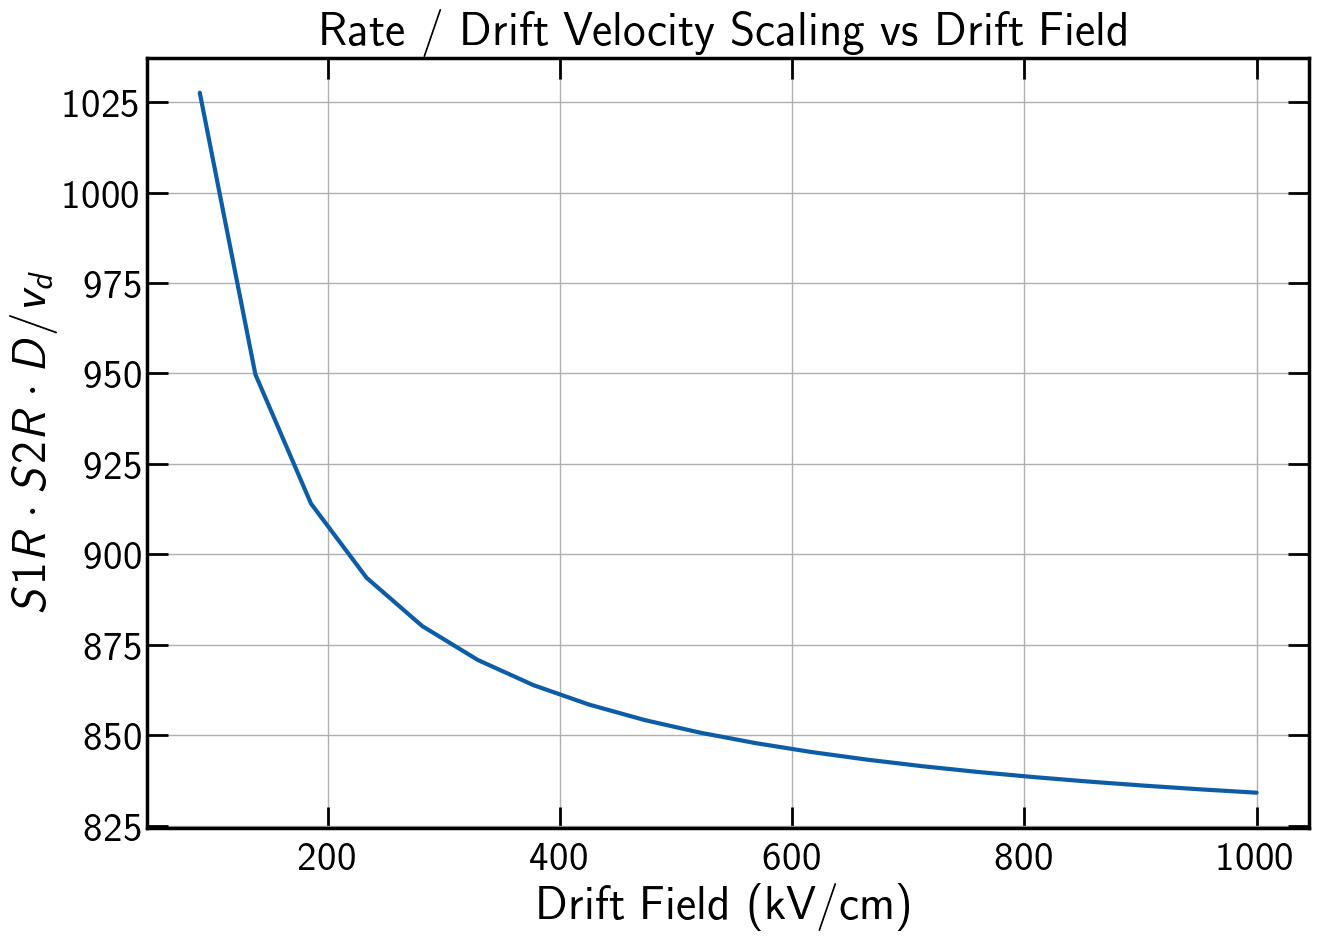

In [5]:
vd_values = np.array([NESTModel.NEST_DV(E) for E in E_fields])  # vd in mm/us or cm/us depending on NEST

quantity = S1R * S2R * D / vd_values

plt.figure()
plt.plot(E_fields, quantity, lw=3)
plt.xlabel("Drift Field (kV/cm)")
plt.ylabel(r"$S1R \cdot S2R \cdot D / v_d$")
plt.title("Rate / Drift Velocity Scaling vs Drift Field")
plt.grid(True)

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

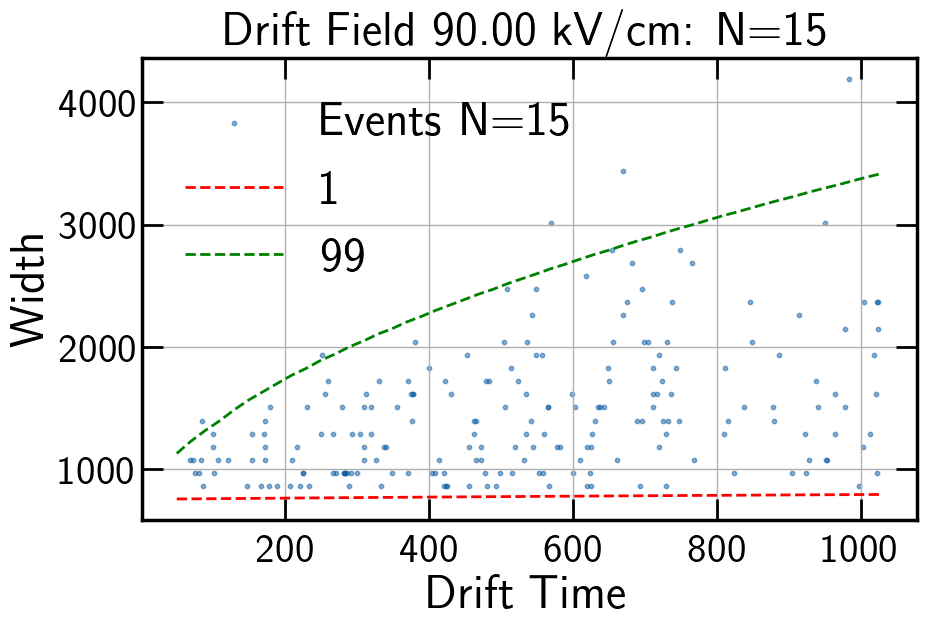

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

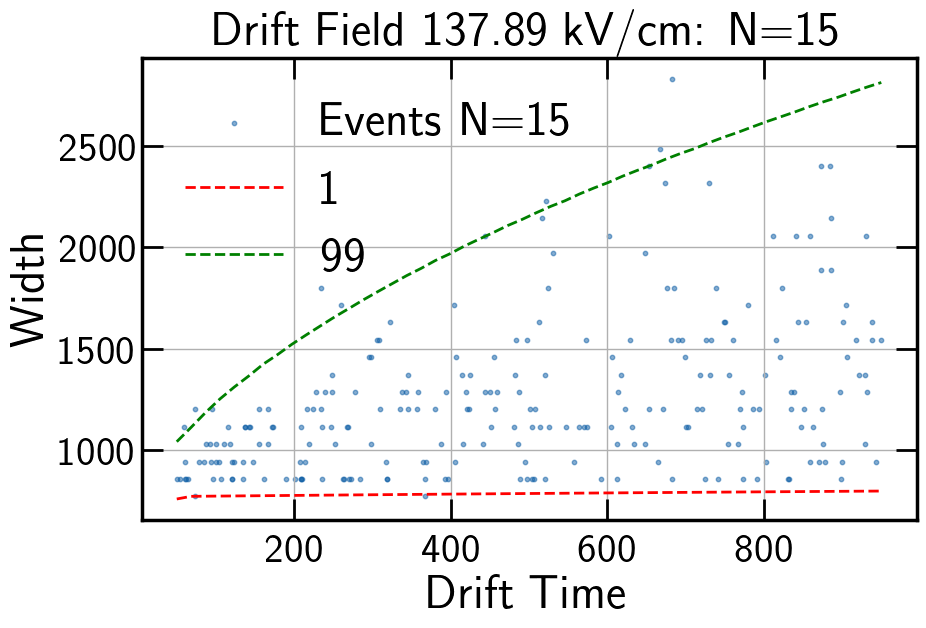

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

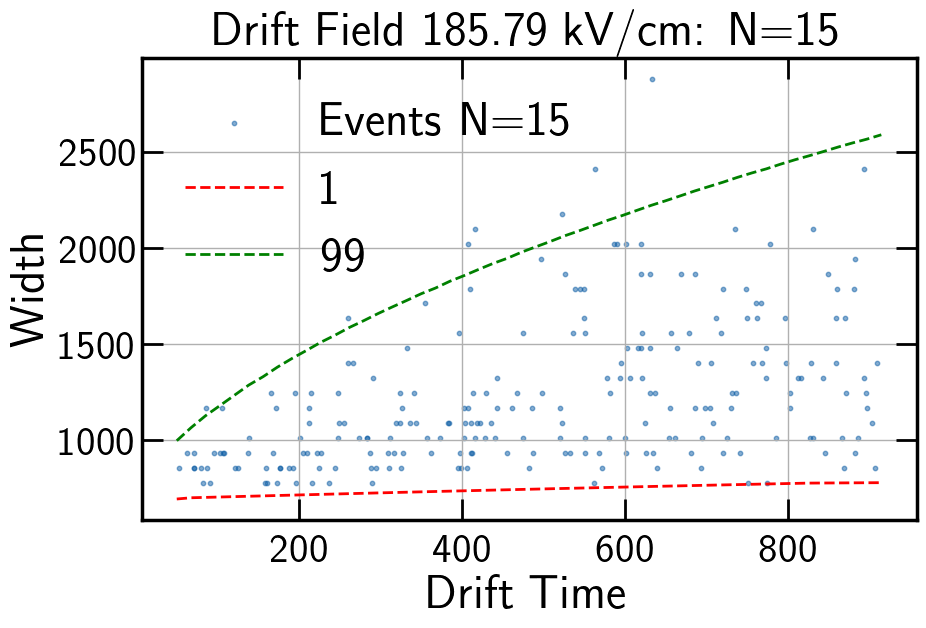

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

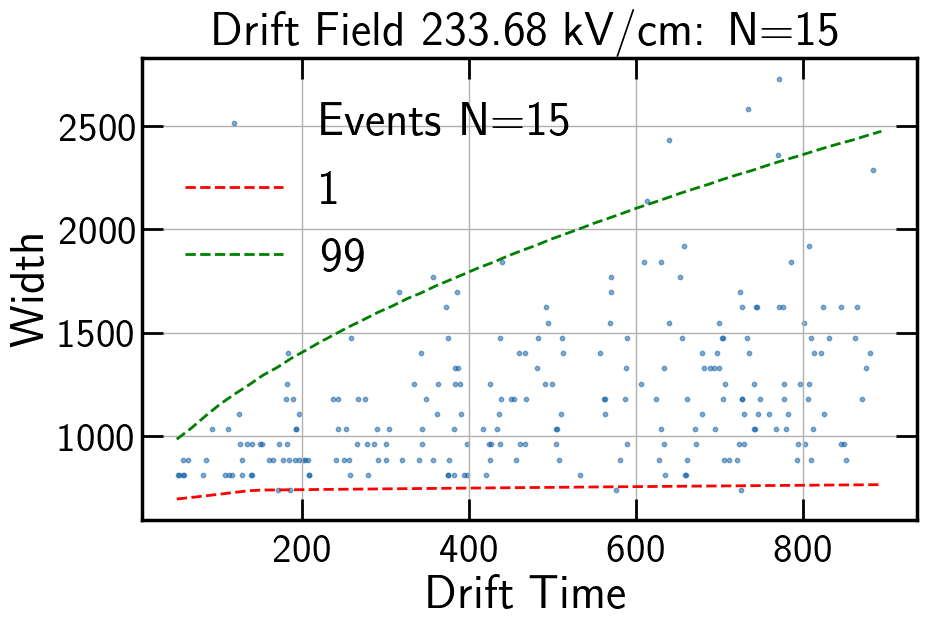

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

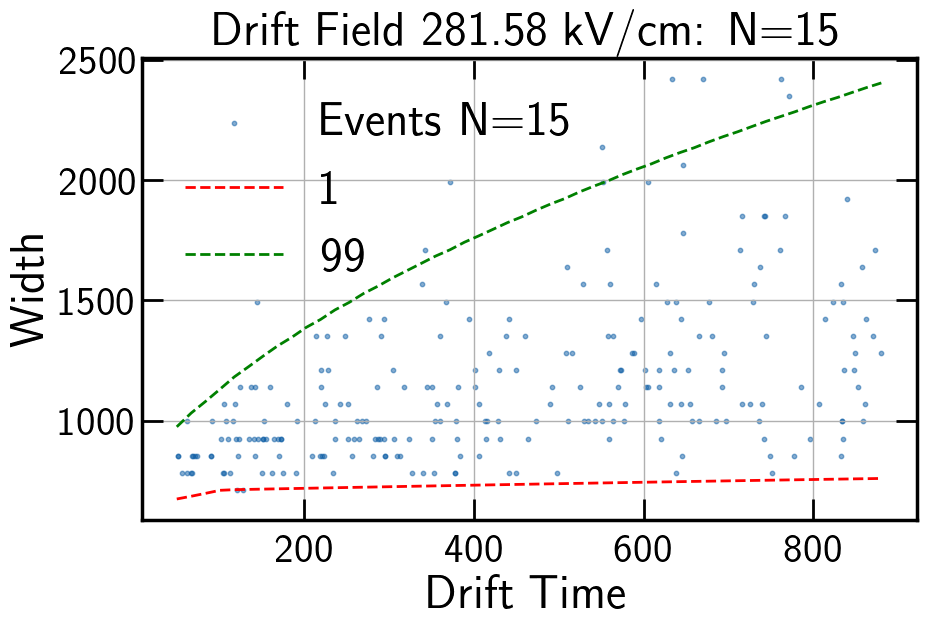

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

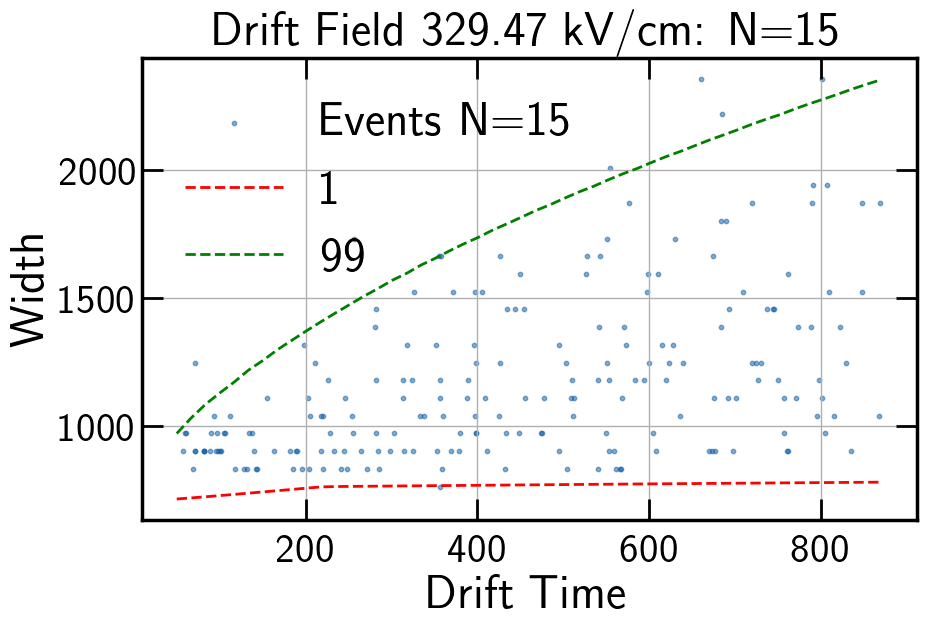

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

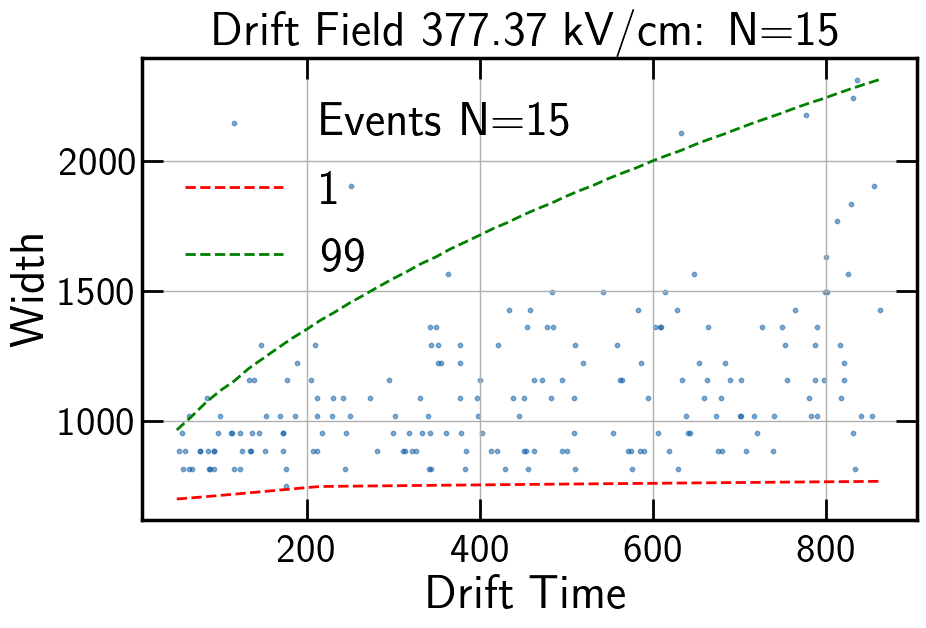

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

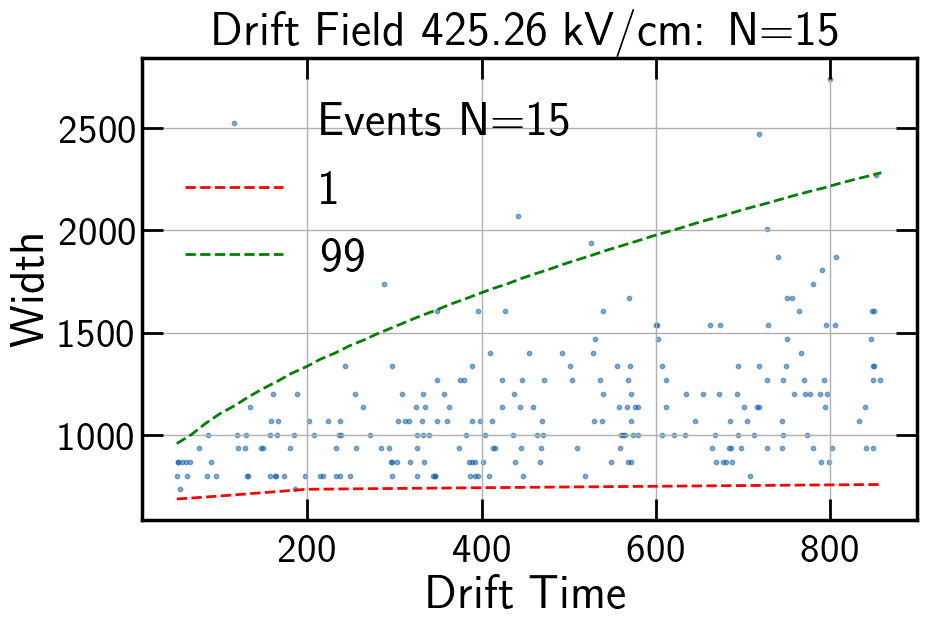

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

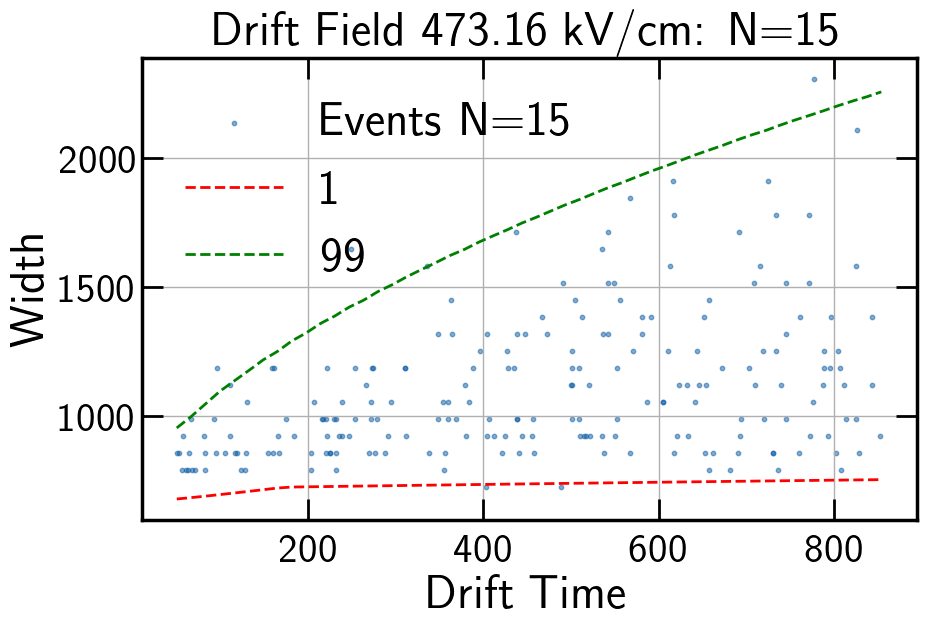

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

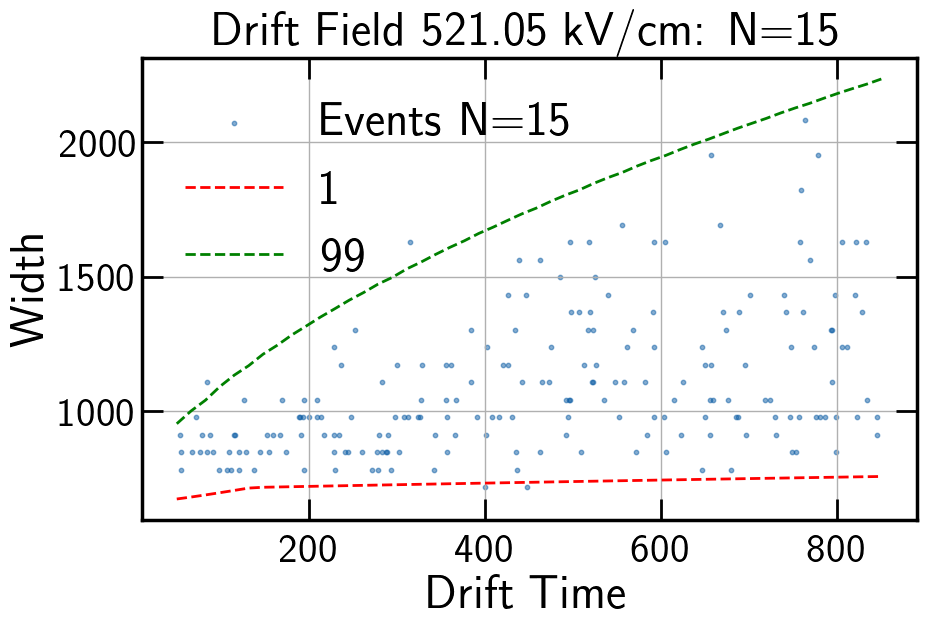

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

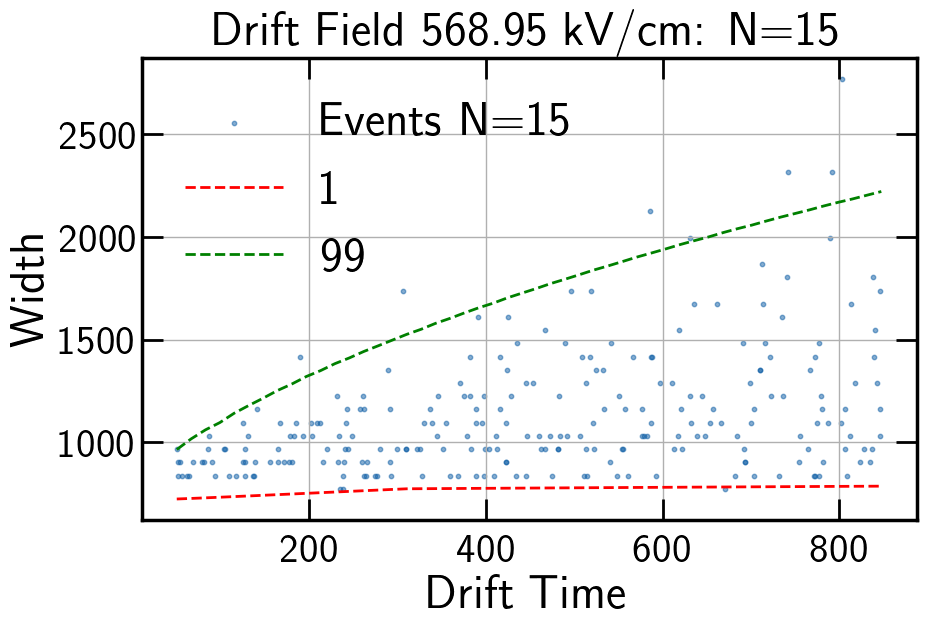

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

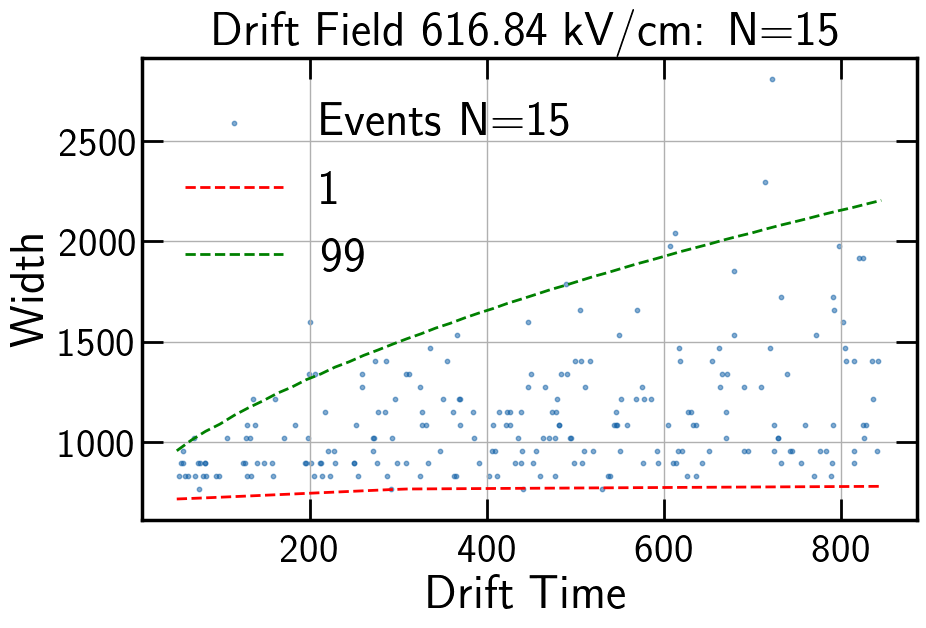

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

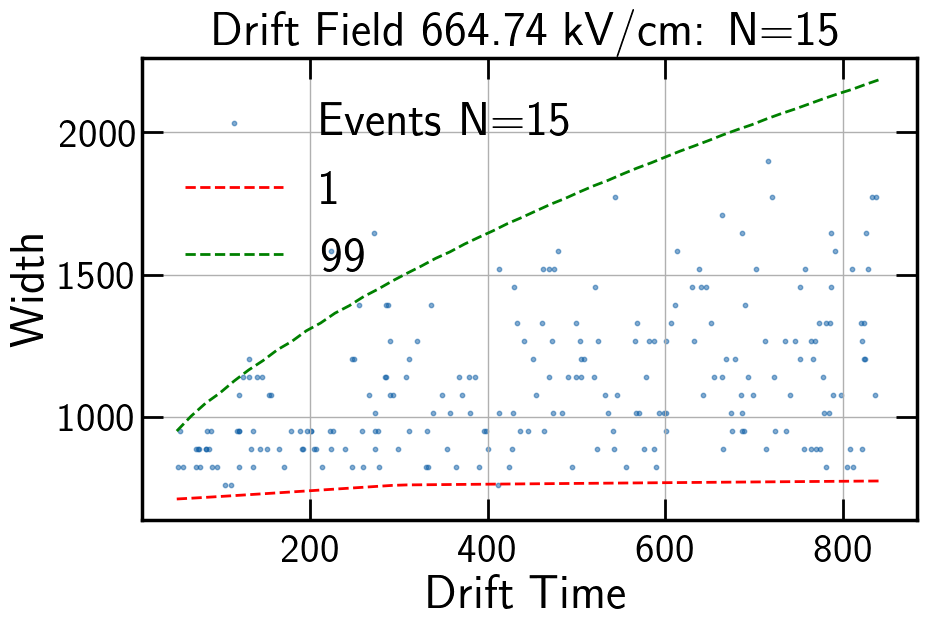

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

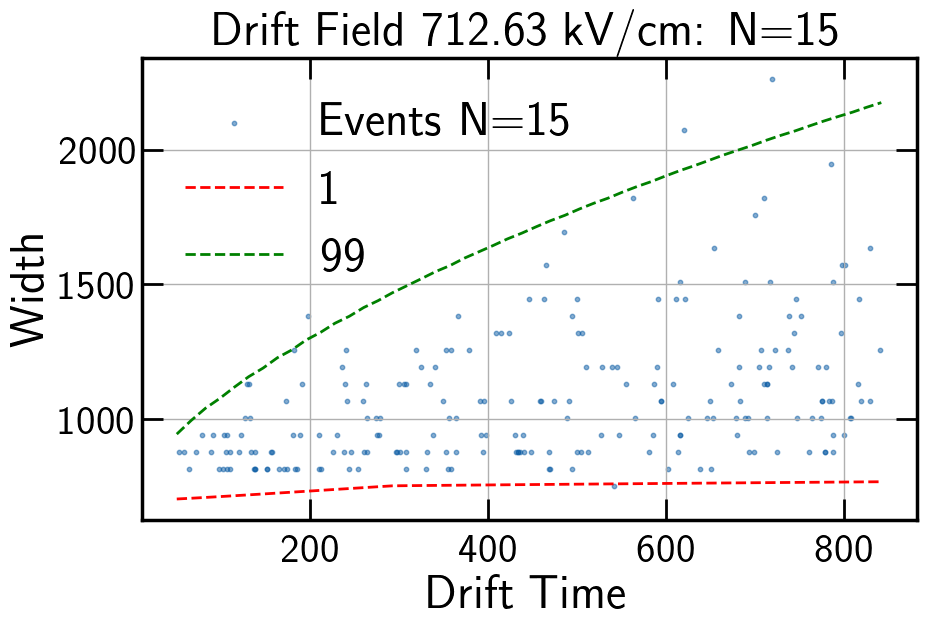

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

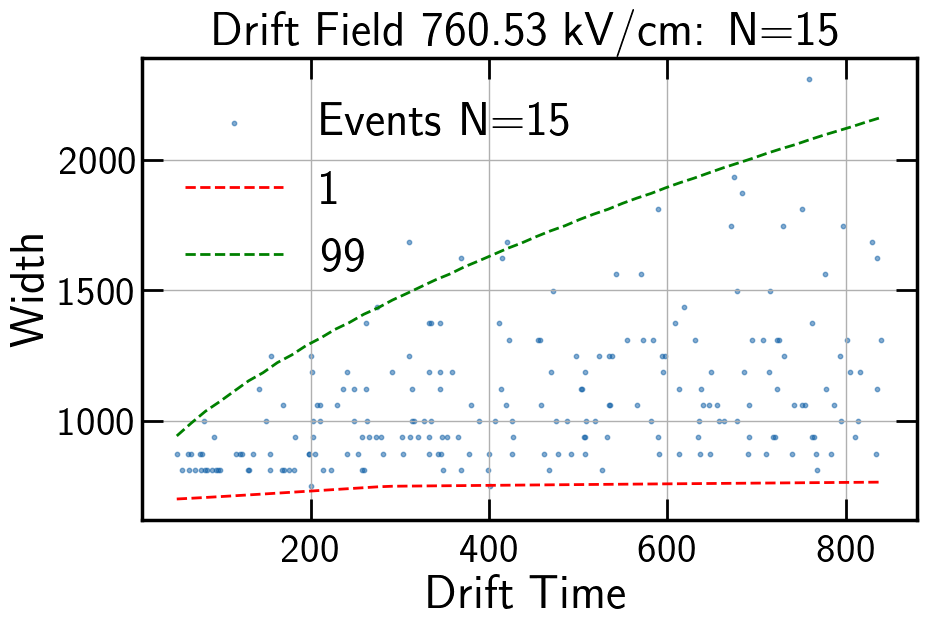

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

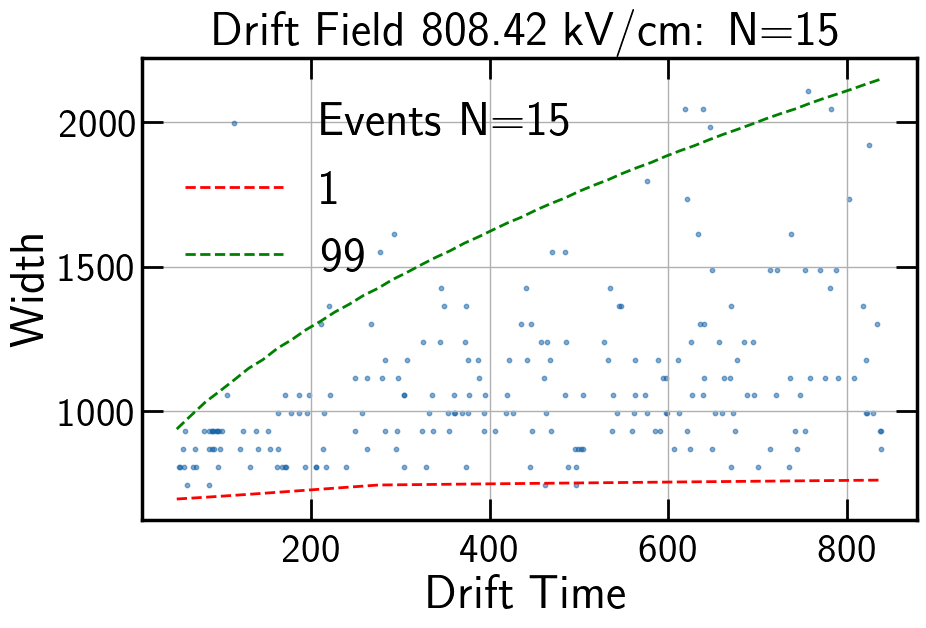

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

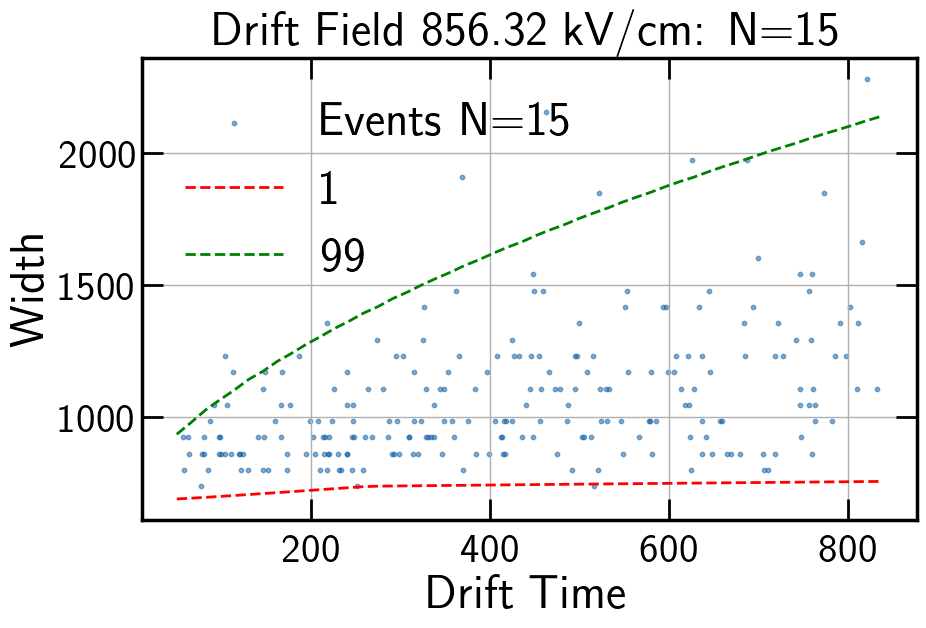

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

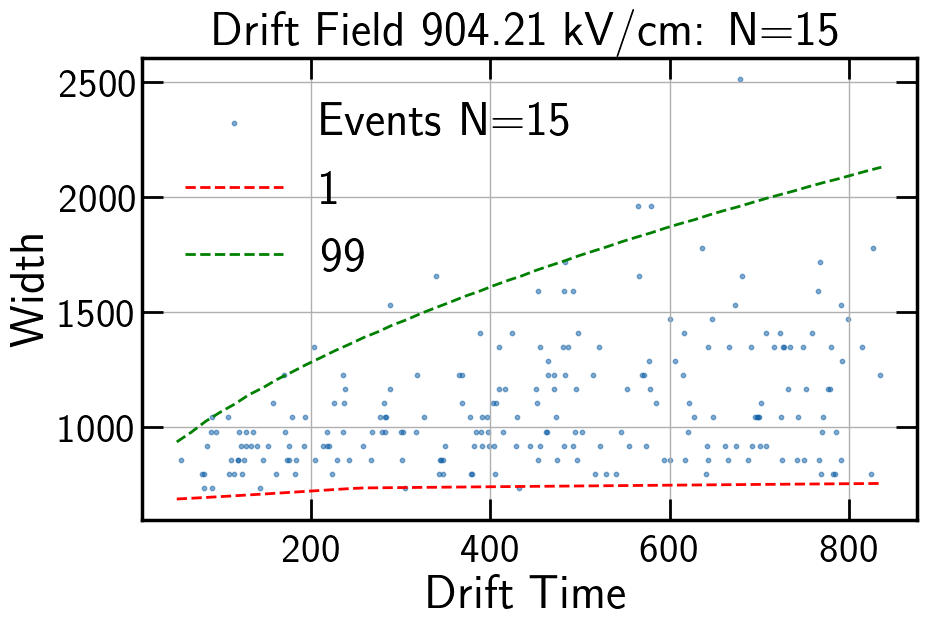

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

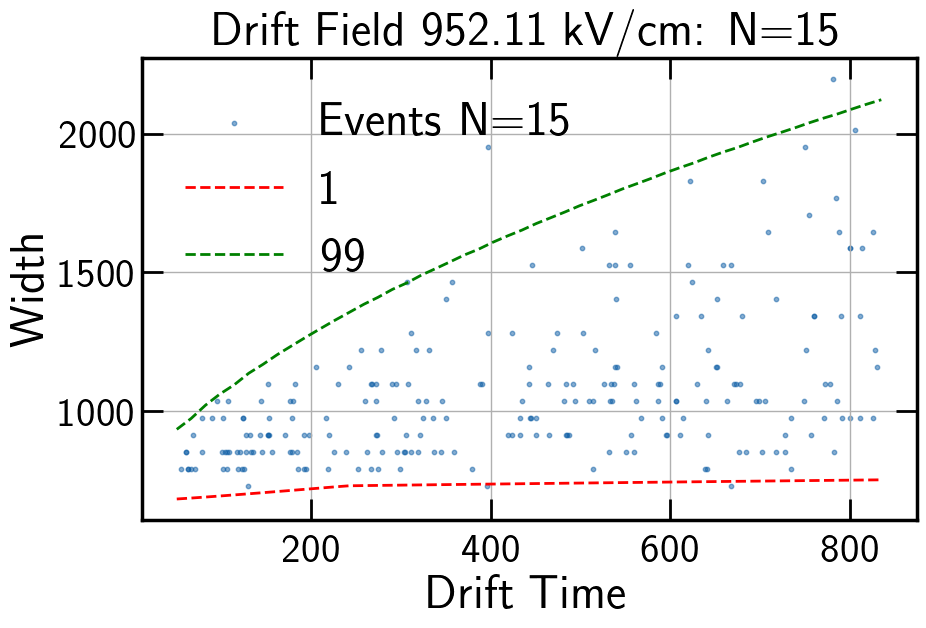

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

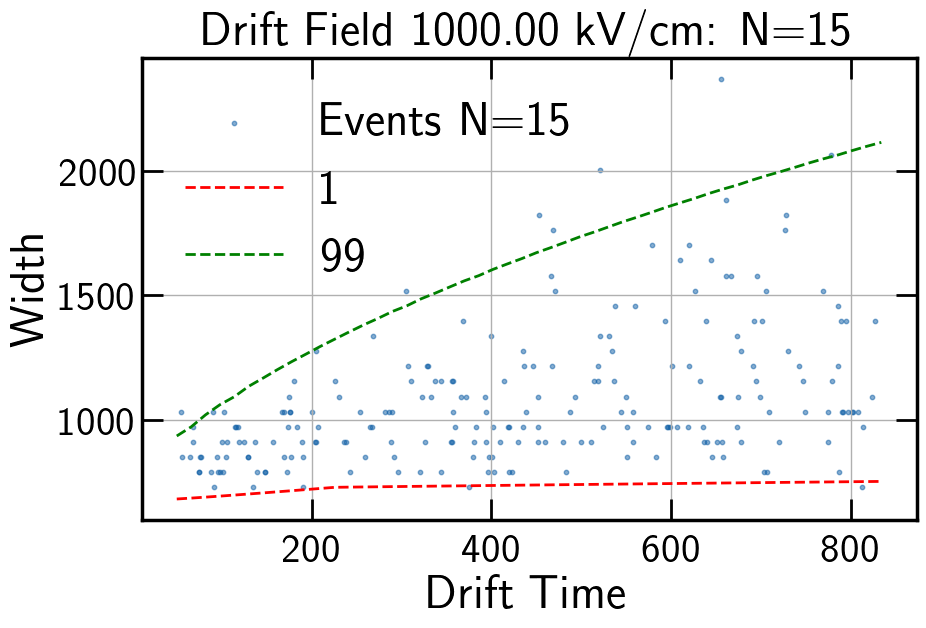

In [6]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

# Target N for visualization
N_target = 15

# -------------------------------
# Loop over drift fields (example)
# -------------------------------
for E_idx, E in enumerate(E_fields):
    vd = NESTModel.NEST_DV(E)
    T_max = D / vd
    DL = NESTModel.NEST_DL(E)
    
    print()
    
    # Build WidthModel
    model = WidthModel(DL, vd, C=775, dC=130, p=0.5, numba_Npts=800)
    
    n_values = np.arange(4, 21)
    drift_times_grid = np.linspace(50, T_max, 50)
    widths_grid = np.linspace(0, 10000, 200)

    # Adaptive width grid based on diffusion
    max_sigma = model.M * np.sqrt(T_max)
    widths_grid = np.linspace(0, 10 * max_sigma, 200)

    model.build_pdf_3d(n_values, drift_times_grid, widths_grid)
    model.lower_bounds, model.upper_bounds = WidthModel.compute_percentile_bounds(model.pdf_3d, model._pdf_widths, lower=2, upper=98.0)

    # -------------------------------
    # Generate random events
    # -------------------------------
    M = 10000
    DT_proxy = np.random.uniform(50, T_max, size=M)  # random drift times
    Ns_cont = sample_exponential_in_range(min(n_values), max(n_values), M)
    Ns = np.rint(Ns_cont).astype(int)
    
    Ws = model.sample(Ns, DT_proxy)
    
    # -------------------------------
    # Plot N_target events with contours
    # -------------------------------
    mask = (np.rint(Ns) == N_target)
    
    if np.any(mask):
        DT_plot = DT_proxy[mask]
        W_plot = Ws[mask]
        
        # Interpolate bounds for N_target
        n_idx = np.argmin(np.abs(model._pdf_n_values - N_target))
        lower_interp = interp1d(model._pdf_drift_times, model.lower_bounds[n_idx, :],
                                bounds_error=False,
                                fill_value=(model._pdf_widths[0], model._pdf_widths[-1]))
        upper_interp = interp1d(model._pdf_drift_times, model.upper_bounds[n_idx, :],
                                bounds_error=False,
                                fill_value=(model._pdf_widths[0], model._pdf_widths[-1]))
        
        dt_grid = model._pdf_drift_times
        lower_contour = lower_interp(dt_grid)
        upper_contour = upper_interp(dt_grid)
        
        plt.figure(figsize=(10,6))
        plt.scatter(DT_plot, W_plot, s=10, alpha=0.5, label=f"Events N={N_target}")
        plt.plot(dt_grid, lower_contour, 'r--', lw=2, label="1% contour")
        plt.plot(dt_grid, upper_contour, 'g--', lw=2, label="99% contour")
        plt.xlabel("Drift Time")
        plt.ylabel("Width")
        plt.title(f"Drift Field {E:.2f} kV/cm: N={N_target}")
        plt.legend()
        plt.grid(True)
        plt.show()


Drift field loop:   0%|                                                                          | 0/20 [00:00<?, ?it/s]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:   5%|███▎                                                              | 1/20 [00:00<00:15,  1.21it/s]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  10%|██████▌                                                           | 2/20 [00:01<00:14,  1.29it/s]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  15%|█████████▉                                                        | 3/20 [00:02<00:13,  1.27it/s]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  20%|█████████████▏                                                    | 4/20 [00:03<00:13,  1.16it/s]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  25%|████████████████▌                                                 | 5/20 [00:04<00:14,  1.06it/s]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  30%|███████████████████▊                                              | 6/20 [00:05<00:14,  1.04s/it]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  35%|███████████████████████                                           | 7/20 [00:07<00:15,  1.19s/it]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  40%|██████████████████████████▍                                       | 8/20 [00:09<00:17,  1.49s/it]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  45%|█████████████████████████████▋                                    | 9/20 [00:10<00:17,  1.55s/it]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  50%|████████████████████████████████▌                                | 10/20 [00:12<00:16,  1.69s/it]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  55%|███████████████████████████████████▊                             | 11/20 [00:14<00:14,  1.63s/it]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  60%|███████████████████████████████████████                          | 12/20 [00:15<00:12,  1.53s/it]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  65%|██████████████████████████████████████████▎                      | 13/20 [00:16<00:09,  1.42s/it]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  70%|█████████████████████████████████████████████▌                   | 14/20 [00:18<00:08,  1.37s/it]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  75%|████████████████████████████████████████████████▊                | 15/20 [00:19<00:07,  1.45s/it]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  80%|████████████████████████████████████████████████████             | 16/20 [00:21<00:06,  1.52s/it]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  85%|███████████████████████████████████████████████████████▎         | 17/20 [00:22<00:04,  1.46s/it]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  90%|██████████████████████████████████████████████████████████▌      | 18/20 [00:24<00:03,  1.53s/it]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop:  95%|█████████████████████████████████████████████████████████████▊   | 19/20 [00:25<00:01,  1.51s/it]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

Drift field loop: 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]


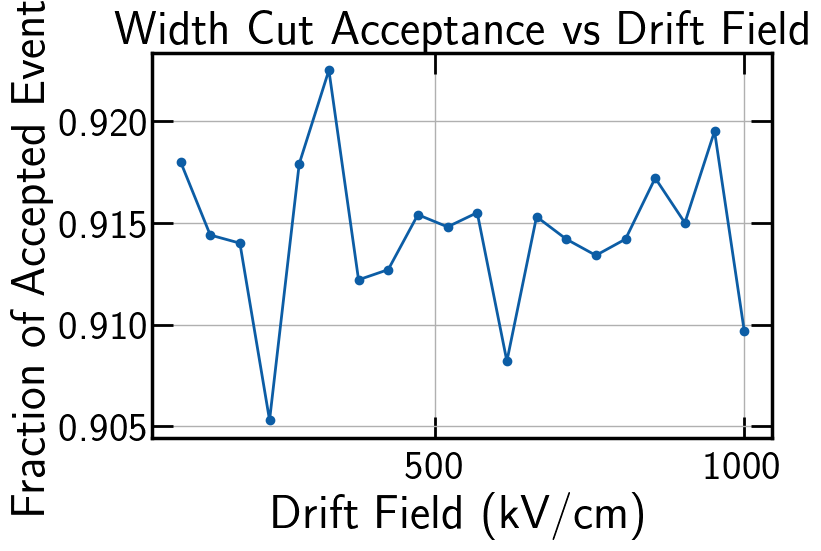

In [8]:
# -------------------------------
# Parameters
# -------------------------------
M = 10000   # number of events per field

accepted_fraction = []

# -------------------------------
# Loop over drift fields
# -------------------------------
for E in tqdm(E_fields, desc="Drift field loop"):
    # Drift velocity
    vd = NESTModel.NEST_DV(E)  # in mm/us
    # Maximum drift time
    T_max = D / vd   # in μs
    
    # Longitudinal diffusion
    DL = NESTModel.NEST_DL(E)  # in mm^2/us

    # -------------------------------
    # Create WidthModel
    # -------------------------------
    model = WidthModel(DL, vd, C=775, dC=140, p=0.5, numba_Npts=800)

    # Define discrete N values and drift times for 3D PDF
    n_values = np.arange(4, 21)  # example N=4..20
    drift_times = np.linspace(50, T_max, 200)  # discrete times to build PDF
    widths = np.linspace(0, 5*DL*T_max, 500)  # width axis in μs

    # Build 3D PDF
    model.build_pdf_3d(n_values, drift_times, widths)
    # Compute percentiles for cuts
    model.lower_bounds, model.upper_bounds = WidthModel.compute_percentile_bounds(model.pdf_3d, model._pdf_widths)
    
    # -------------------------------
    # Generate random N and drift times
    # -------------------------------
    
    # Uniform distribution
    Ns = np.random.choice(n_values, size=M)
    DTs = np.random.uniform(50, T_max, size=M)  # randomized drift time per event

    # Exponential
    #DTs = sample_exponential_in_range(50, T_max, M)
    #Ns_cont = sample_exponential_in_range(min(n_values), max(n_values), M)
    #Ns = np.rint(Ns_cont).astype(int)
    
    # Sample widths using the PDF
    Ws = model.sample(Ns, DTs)

    # Randomize drift time to simulate accidental pairing
    DT_proxy = np.random.uniform(50, T_max, M)

    # Interpolate bounds for each event at N, DT_proxy
    lower_bounds_interp = np.zeros(M)
    upper_bounds_interp = np.zeros(M)
    for i, N_ev in enumerate(Ns):
        n_idx = np.argmin(np.abs(model._pdf_n_values - N_ev))
        lower_bounds_interp[i] = np.interp(DT_proxy[i], model._pdf_drift_times, model.lower_bounds[n_idx, :])
        upper_bounds_interp[i] = np.interp(DT_proxy[i], model._pdf_drift_times, model.upper_bounds[n_idx, :])

    accepted = (Ws >= lower_bounds_interp) & (Ws <= upper_bounds_interp)
    accepted_fraction.append(np.mean(accepted))

# -------------------------------
# Plot fraction of accepted events vs drift field
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(E_fields, accepted_fraction, marker='o', lw=2)
plt.xlabel("Drift Field (kV/cm)")
plt.ylabel("Fraction of Accepted Events")
plt.title("Width Cut Acceptance vs Drift Field")
plt.grid(True)
plt.show()


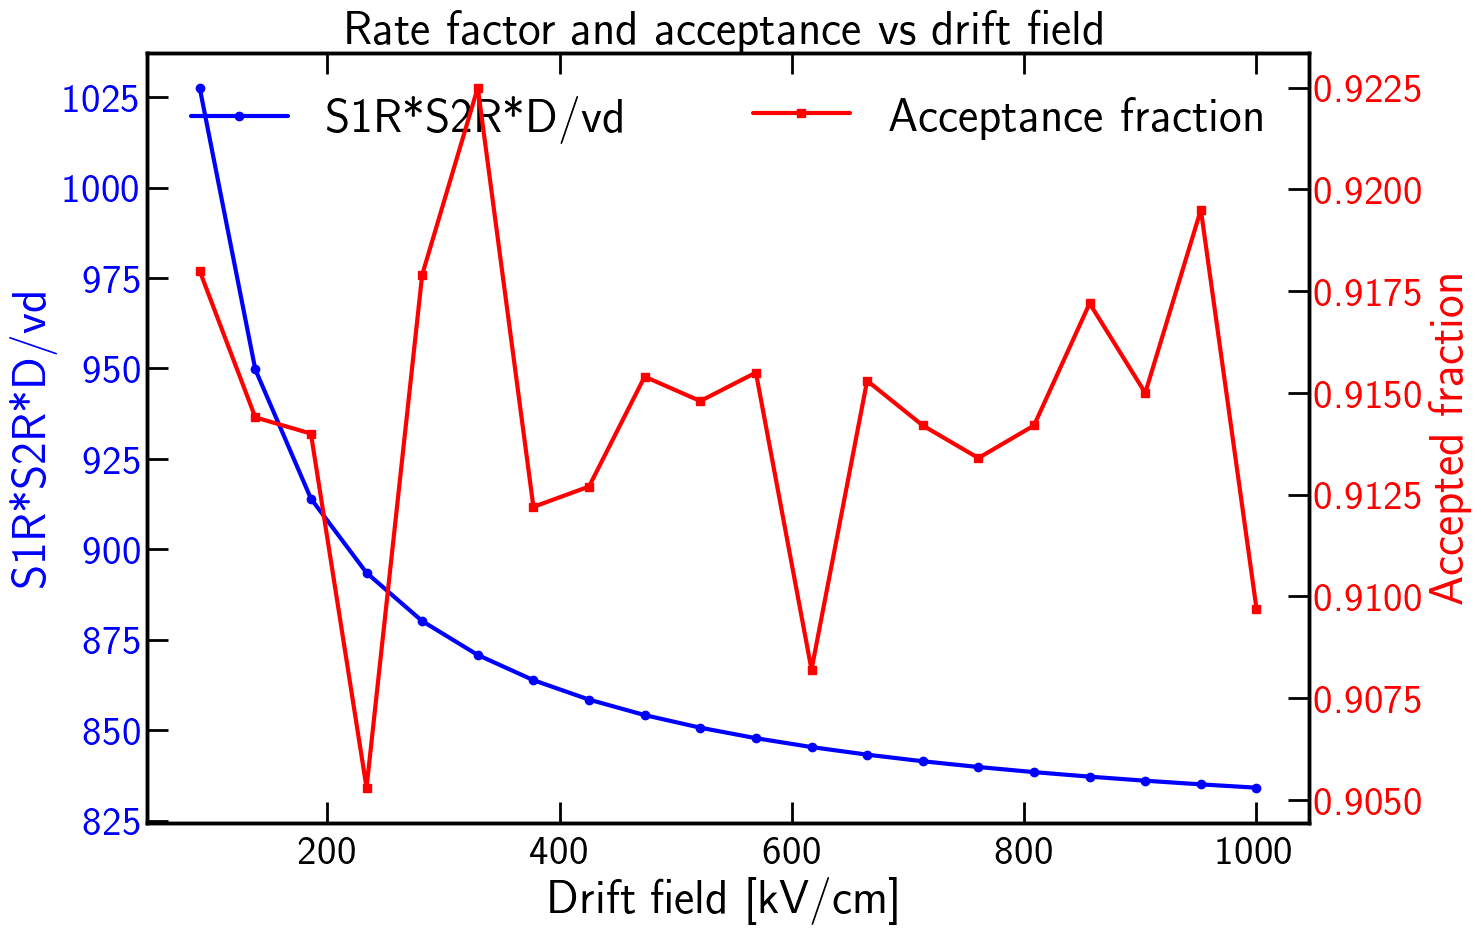

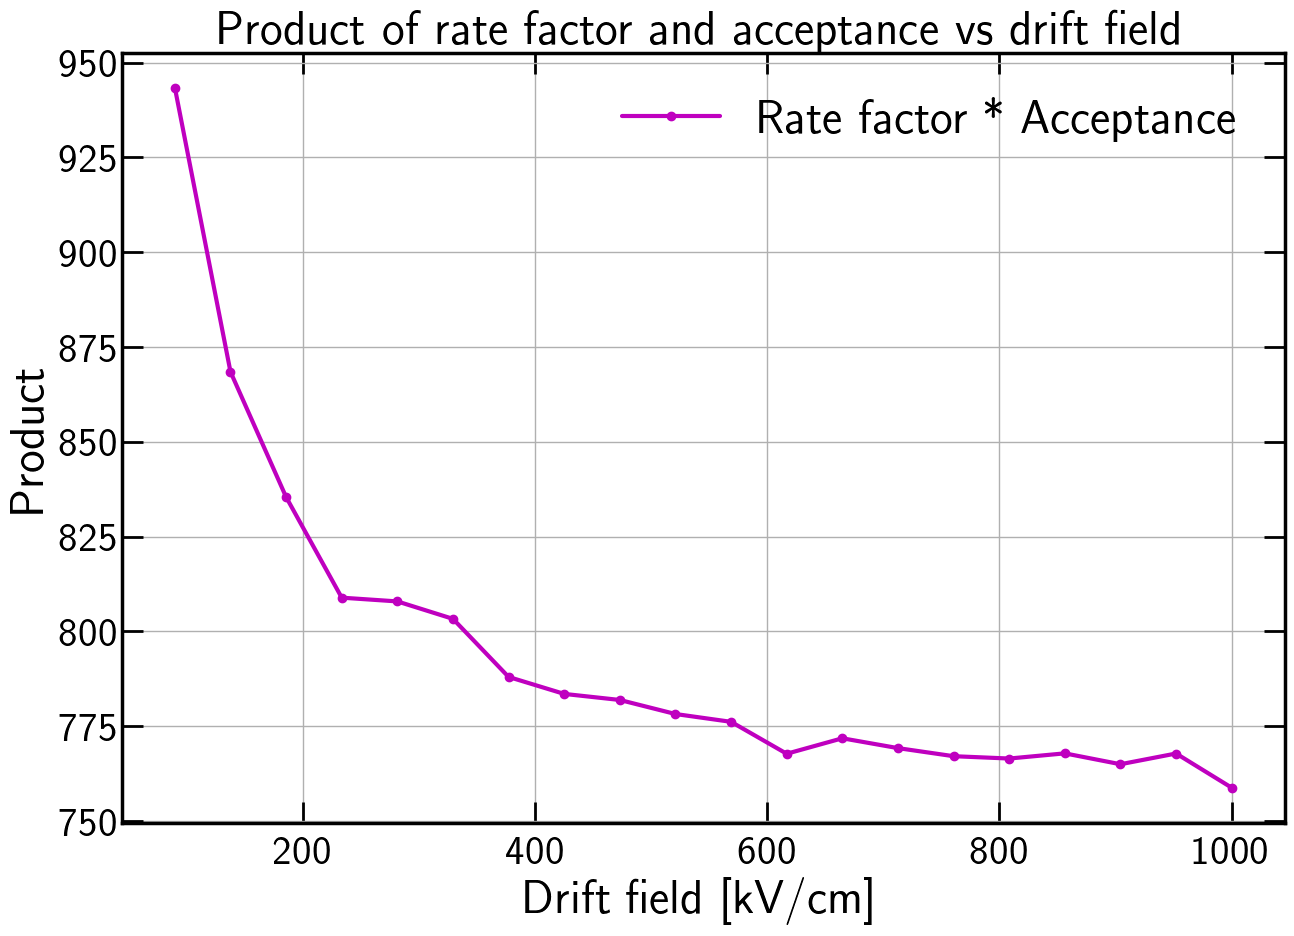

In [9]:
# Compute S1R*S2R*D/vd
rate_factor = S1R * S2R * D / vd_values
product = rate_factor * accepted_fraction

# --- Twin axis plot ---
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(E_fields, rate_factor, 'b-o', label='S1R*S2R*D/vd')
ax2.plot(E_fields, accepted_fraction, 'r-s', label='Acceptance fraction')

ax1.set_xlabel("Drift field [kV/cm]")
ax1.set_ylabel("S1R*S2R*D/vd", color='b')
ax2.set_ylabel("Accepted fraction", color='r')

ax1.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title("Rate factor and acceptance vs drift field")
plt.show()

# --- Separate plot of the product ---
plt.figure()
plt.plot(E_fields, product, 'm-o', label='Rate factor * Acceptance')
plt.xlabel("Drift field [kV/cm]")
plt.ylabel("Product")
plt.title("Product of rate factor and acceptance vs drift field")
plt.grid(True)
plt.legend()
plt.show()